<a href="https://colab.research.google.com/github/mohdulo/IA_Et_Tests_Automatises/blob/main/Projet_%E2%80%93_D%C3%A9veloppement_et_tests_automatis%C3%A9s_d%E2%80%99une_solution_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

import xgboost as xgb

#from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

import pickle

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')  # Adapte le chemin au fichier téléchargé
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<Axes: >

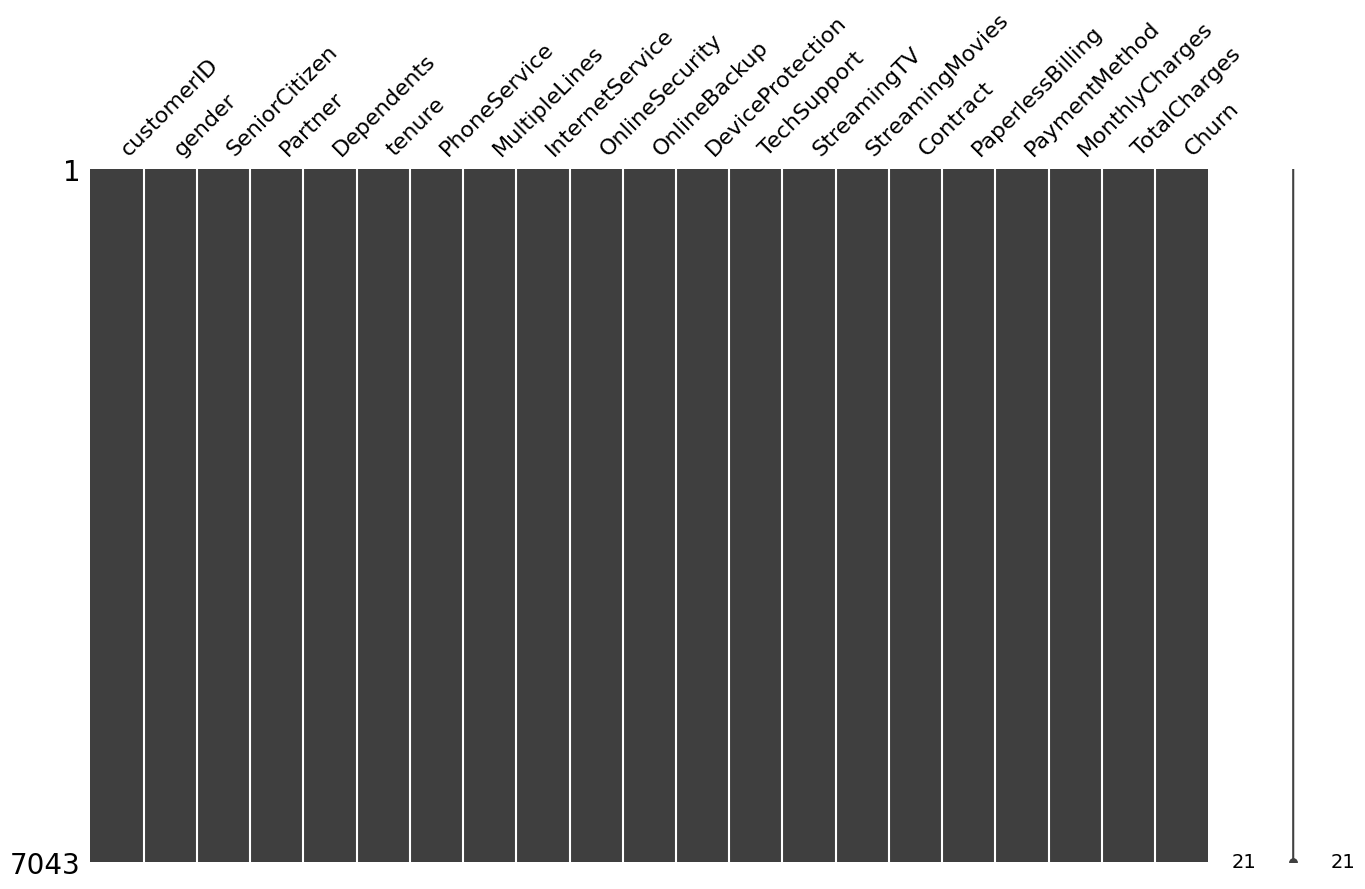

In [ ]:
mno.matrix(df, figsize=(16,9))

In [ ]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# prompt: donne moi les type de colonnes de mon df

df.dtypes


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [ ]:
# Convertir en float (certaines valeurs peuvent être vides ou mal formatées)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


# Supprimer les espaces blancs autour des chaînes
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


# Colonnes binaires à convertir manuellement
binary_map = {
    'Yes': 1,
    'No': 0,
    'Male': 1,
    'Female': 0
}

for col in ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df[col] = df[col].map(binary_map)


    multi_cat_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]

df = pd.get_dummies(df, columns=multi_cat_cols)

# customerID est un identifiant, pas une variable utile pour le modèle
df.drop('customerID', axis=1, inplace=True)


# 7. Vérification finale
print(df.dtypes)
print(df.shape)
df.head()

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
MultipleLines_No                              bool
MultipleLines_No phone service                bool
MultipleLines_Yes                             bool
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No                            bool
OnlineSecurity_No                             bool
OnlineSecurity_No internet service            bool
OnlineSecurity_Yes                            bool
OnlineBackup_No                

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


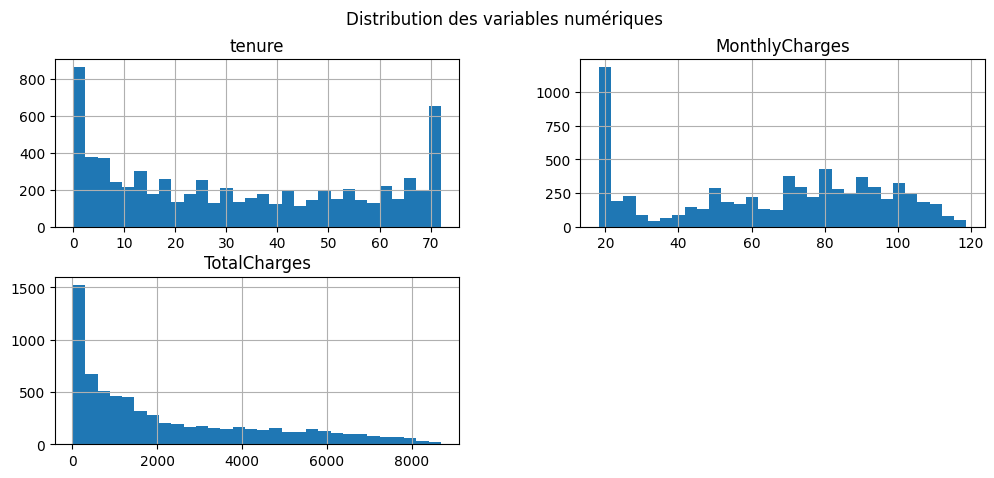

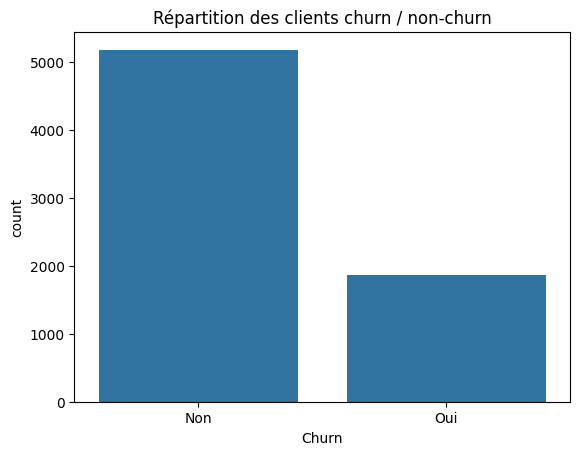

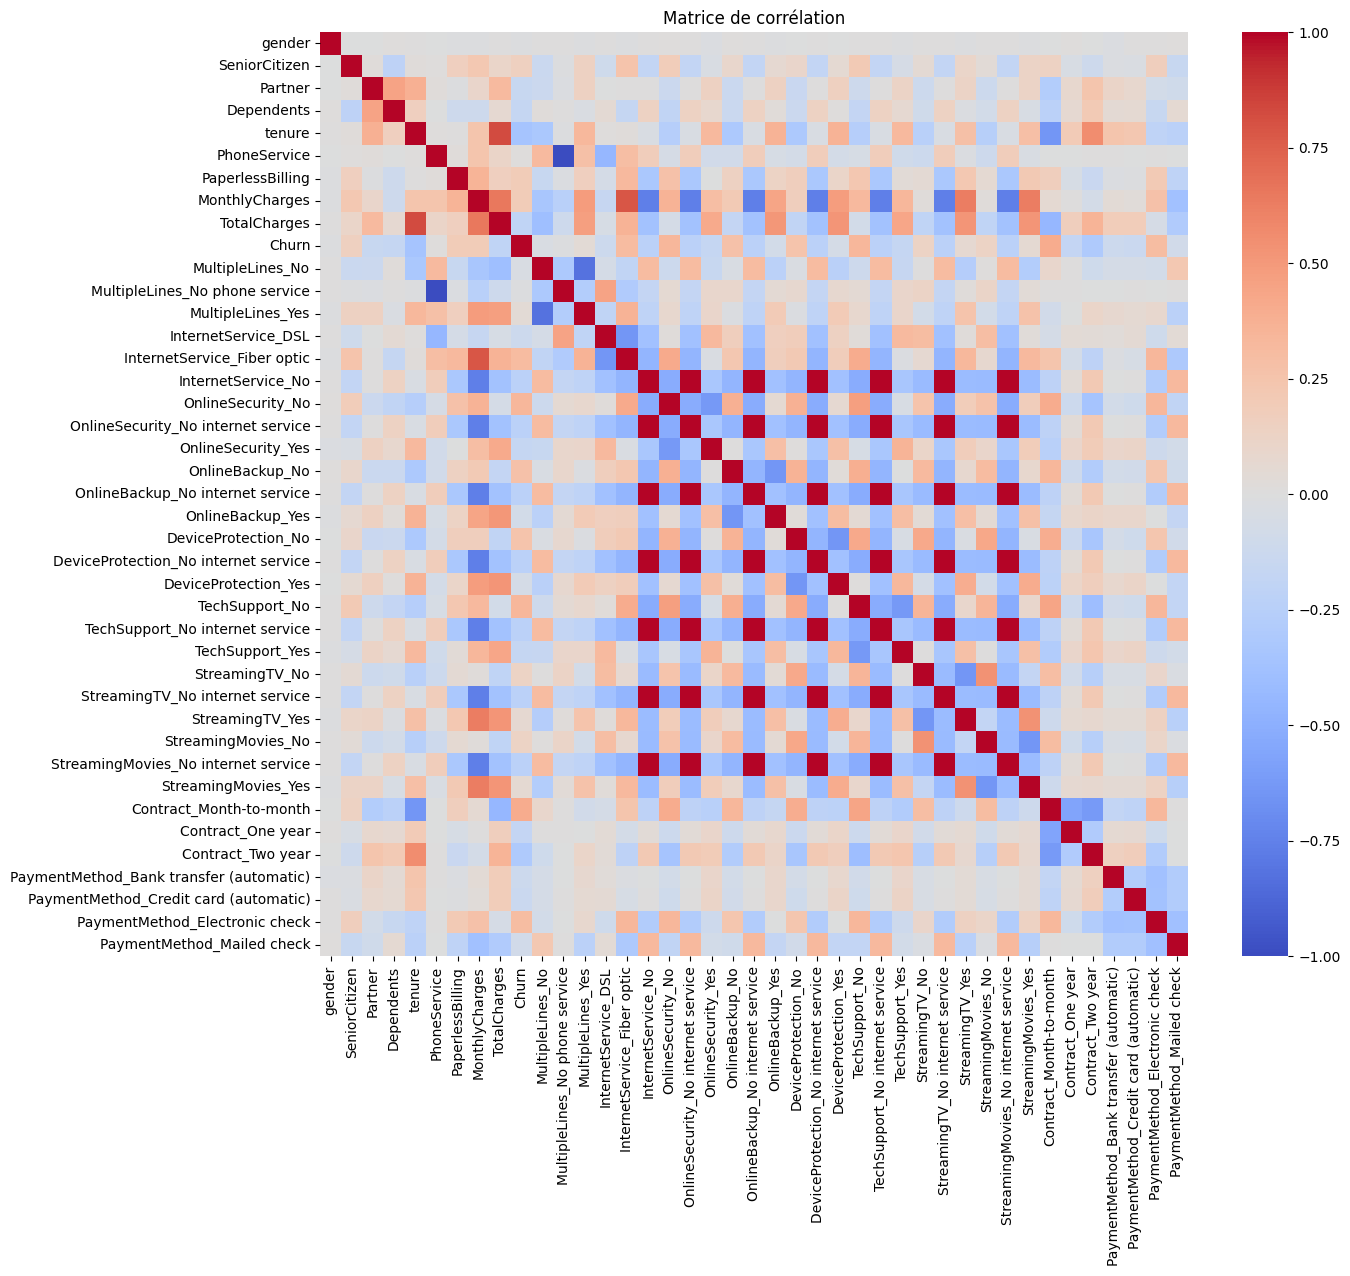

In [ ]:
# Histogrammes des variables continues
df[['tenure', 'MonthlyCharges', 'TotalCharges']].hist(bins=30, figsize=(12, 5))
plt.suptitle("Distribution des variables numériques")
plt.show()

# Répartition du churn
sns.countplot(x='Churn', data=df)
plt.title('Répartition des clients churn / non-churn')
plt.xticks([0, 1], ['Non', 'Oui'])
plt.show()

# Corrélation
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Matrice de corrélation')
plt.show()


In [ ]:
# Sauvegarde d’un exemple de ligne complète au format dict
example_dict = X_train.iloc[0].to_dict()

# Affichage
import pprint
pprint.pprint(example_dict)


{'Contract_Month-to-month': False,
 'Contract_One year': True,
 'Contract_Two year': False,
 'Dependents': 1,
 'DeviceProtection_No': False,
 'DeviceProtection_No internet service': False,
 'DeviceProtection_Yes': True,
 'InternetService_DSL': True,
 'InternetService_Fiber optic': False,
 'InternetService_No': False,
 'MonthlyCharges': 64.85,
 'MultipleLines_No': True,
 'MultipleLines_No phone service': False,
 'MultipleLines_Yes': False,
 'OnlineBackup_No': True,
 'OnlineBackup_No internet service': False,
 'OnlineBackup_Yes': False,
 'OnlineSecurity_No': False,
 'OnlineSecurity_No internet service': False,
 'OnlineSecurity_Yes': True,
 'PaperlessBilling': 0,
 'Partner': 0,
 'PaymentMethod_Bank transfer (automatic)': False,
 'PaymentMethod_Credit card (automatic)': False,
 'PaymentMethod_Electronic check': False,
 'PaymentMethod_Mailed check': True,
 'PhoneService': 1,
 'SeniorCitizen': 0,
 'StreamingMovies_No': False,
 'StreamingMovies_No internet service': False,
 'StreamingMovies_Y

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


In [ ]:
# Sauvegarde de l’ordre des colonnes utilisées pendant l'entraînement
feature_order = X_train.columns.tolist()

# Pour générer une ligne de test cohérente
example = X_train.iloc[0].to_dict()


In [ ]:
import joblib
joblib.dump(feature_order, "feature_order.pkl")


['feature_order.pkl']

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.48      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.78      0.80      0.79      1409



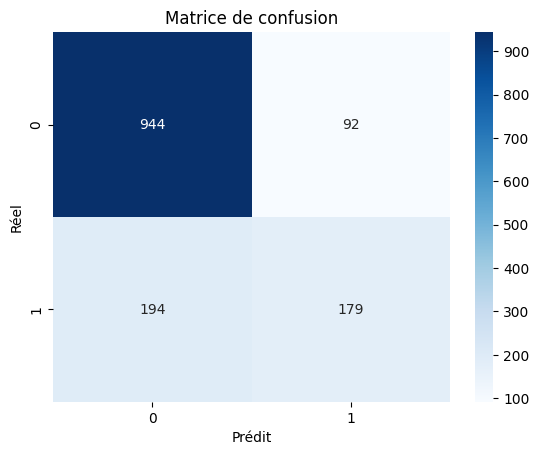

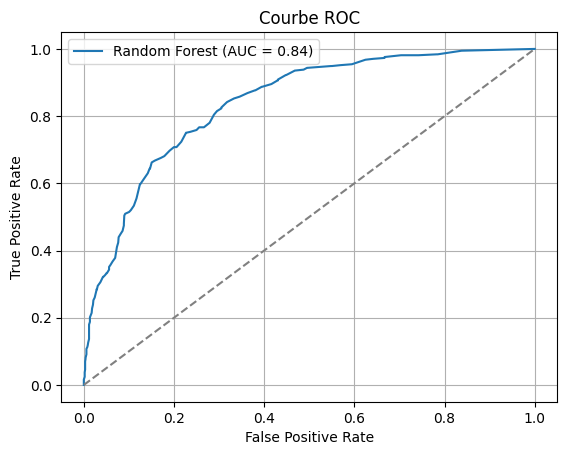

In [ ]:
print("Classification Report :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# ROC Curve
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib

# Sauvegarde du modèle entraîné
joblib.dump(model, 'random_forest_churn_model.pkl')
print("✅ Modèle sauvegardé sous 'random_forest_churn_model.pkl'")


✅ Modèle sauvegardé sous 'random_forest_churn_model.pkl'


In [ ]:
# Exemple depuis un notebook
import pandas as pd

# new_client doit avoir les mêmes colonnes que X_train
new_client = pd.DataFrame([X_test.iloc[0]])  # par exemple, copier une ligne

# Sauvegarder au format Pickle
new_client.to_pickle('new_client.pkl')


In [ ]:
# prompt: affiche les colonnes

df.columns


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMetho